# Dimensionality Reduction

降低維度確實會丟失一些信息（就像將圖像壓縮為 JPEG 會降低其質量一樣），因此即使它會加快訓練速度，也可能會使整體模型性能稍差。 它還使管道更加複雜，因此更難維護。 所以應該先嘗試用原始數據訓練，然後如果訓練太慢的話，再考慮使用降維。 在某些情況下，降低訓練數據的維度可能會過濾掉一些噪音和不必要的細節，從而獲得更高的性能（但通常不會；它只會加快訓練速度）。

Three of the most popular dimensionality reduction techniques: 

* PCA

* Kernel PCA

* LLE

## Setup

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import IncrementalPCA
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding
from matplotlib.colors import ListedColormap


為了防止一些Sklearn更新的不必要警告:

In [2]:
# import warnings filter
from warnings import simplefilter
import warnings
#ugnore all future warnings
simplefilter(action='ignore', category=FutureWarning)

And let's create the images/dim_reduction folder (if it doesn't already exist), and define the save_fig() function which is used through this notebook to save the figures in high-res for the book:

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# PCA

使用Mnist資料集

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

原本共有785個特徵

In [7]:
X_train.shape

(60000, 784)

簡單使用PCA並保留95%的variance

In [9]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [10]:
pca.n_components_

154

剩下154維。每個observation將具有 154 多個特徵，而不是原來的 784 個特徵。 因此，雖然保留了大部分variance(95%)，但數據集現在還不到其原始大小的 20%！ 這是一個很好的壓縮，將極大地加速一些分類算法（例如 SVM 分類器）。

也可以包進pipeline裡面並且在參數搜索時tune維度的數量

In [16]:
clf = Pipeline(
    [("pca", PCA(random_state=42)), 
    ("rf", RandomForestClassifier(random_state=42))]
    )
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "rf__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67,...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [17]:
print(rnd_search.best_params_)

{'rf__n_estimators': 465, 'pca__n_components': 23}


從765維減少到23維

還可以通過應用 PCA 投影的逆變換將減少的數據集解壓縮回 784 維。 當然這不會返回原始數據，因為投影丟失了一些信息（在被丟棄的 5% 方差內），但它可能非常接近原始數據。 原始數據和重構數據（壓縮後解壓）之間的均方距離稱為重構誤差(reconstruction error)。 例如，以下代碼將 MNIST 數據集壓縮到 154 維，然後使用 inverse_transform() 方法將其解壓縮回 784 維。

In [18]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [19]:
X_recovered = pca.inverse_transform(X_reduced)

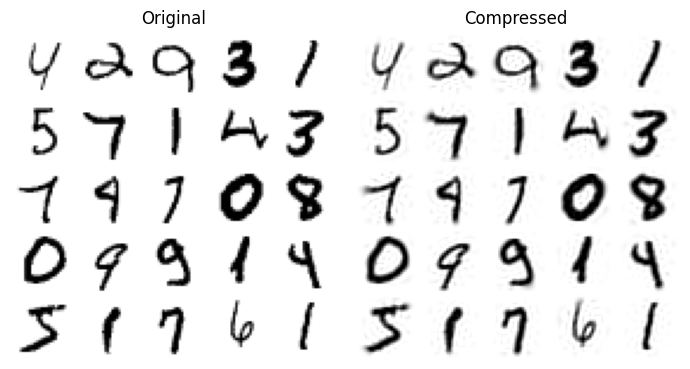

In [20]:
# extra code – this cell generates and saves Figure 8–9

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

save_fig("mnist_compression_plot")

## Incremental PCA

PCA的一個問題是它們需要整個訓練集適合內存才能運行算法。 幸運的是，已經開發了Incremental PCA (IPCA) 算法，可以將訓練集分成小批量，並一次為 IPCA 算法提供一個批量。 這對於大型訓練集很有用，也適用於在線應用 PCA（即，在新observation到達時即時應用）。 

以下代碼將 MNIST 數據集拆分為 100 個小批次（使用 NumPy 的 array_split() 函數）並將它們提供給 Scikit-Learn 的 IncrementalPCA，以將 MNIST 數據集的維數減少到 154 維（就像之前一樣）。 請注意，必須對每個小批量調用 partial_fit() 方法，而不是對整個訓練集調用 fit() 方法：

In [22]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

# LLE

製造一個swiss roll資料，並使用LLE降維

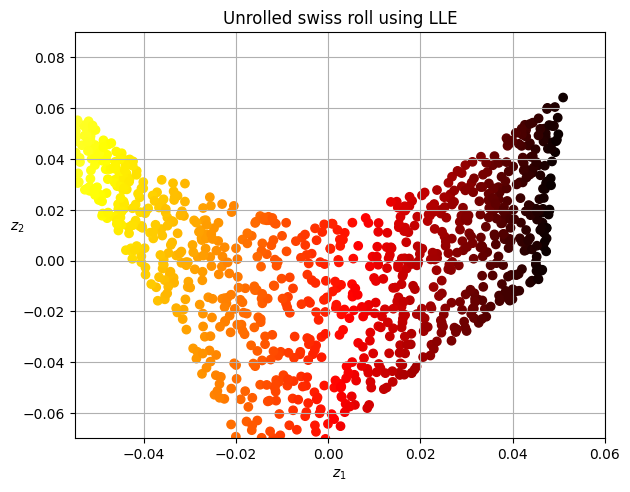

In [9]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding
from matplotlib.colors import ListedColormap

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

# extra code – generates Figure 
darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.title("Unrolled swiss roll using LLE")
plt.show()

# 其他降維技巧

* Multidimensional Scaling (MDS) 在嘗試保留observation之間的距離的同時降低維度。( random projection做一樣的事，但適用於高維數據而不適用於低維數據。)
sklearn.manifold.MDS



In [11]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

* Isomap 通過將每個observation連接到其最近的鄰居來創建一個圖，然後在嘗試保留observation之間的測地線距離(geodesic distances)的同時降低維度。不適用於低維數據。
sklearn.manifold.Isomap

In [12]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

* t-Distributed Stochastic Neighbor Embedding (t-SNE) 降低了維度，同時試圖使相似的observation保持接近並使不同的observation分開。 它主要用於可視化，特別是在高維空間中可視化observation集群（例如，在 2D 中可視化 MNIST 圖像）。
sklearn.manifold.TSNE

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

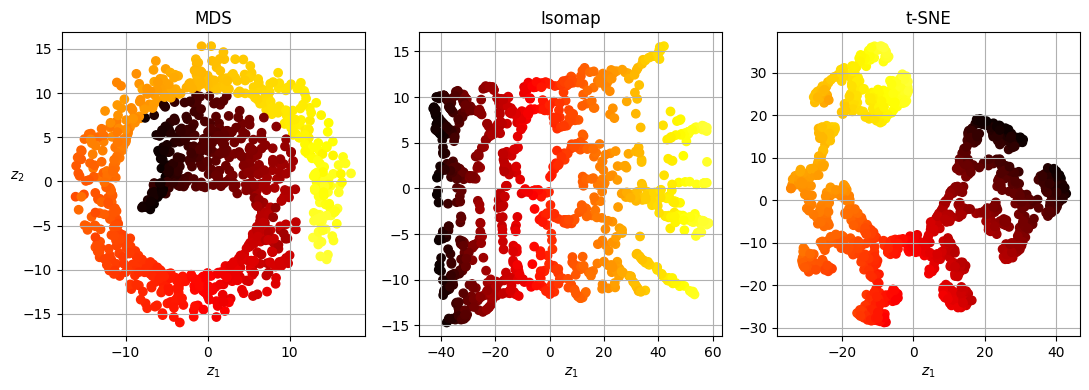

In [14]:
# extra code – this cell generates and saves Figure 8–11

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()